In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show  # noqa: E402

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

def input_output_response_to_pandas(response: ct.input_output_response):
    # until this gets merged: https://github.com/python-control/python-control/issues/957
    data = {'time': response.time}
    if response.ninputs > 0:
        data.update(
            {name: response.inputs[i] for i, name in enumerate(response.input_labels)})
    if response.noutputs > 0:
        data.update(
            {name: response.outputs[i] for i, name in enumerate(response.output_labels)})
    if response.nstates > 0:
        data.update(
            {name: response.states[i] for i, name in enumerate(response.state_labels)})
    return pd.DataFrame(data)

# Data

In [11]:
tzinfo = timezone("America/Sao_Paulo")

events = [
    {
        "name": "01.Curta",
        "start": pd.Timestamp(
            year=2020, month=1, day=29, hour=13, minute=51, second=59, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=29, hour=14, minute=20, second=25, tzinfo=tzinfo
        ),
    },
    {
        "name": "02.Longa",
        "start": pd.Timestamp(
            year=2020, month=1, day=30, hour=11, minute=16, second=45, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=30, hour=14, minute=55, second=30, tzinfo=tzinfo
        ),
    },
    {
        "name": "03.Revezamento",
        "start": pd.Timestamp(
            year=2020, month=1, day=31, hour=11, minute=23, second=23, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=1, day=31, hour=12, minute=27, second=23, tzinfo=tzinfo
        ),
    },
    {
        "name": "04.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=10, minute=15, second=15, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=11, minute=37, second=28, tzinfo=tzinfo
        ),
    },
    {
        "name": "05.Curta",
        "start": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=15, second=9, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=1, hour=13, minute=32, second=55, tzinfo=tzinfo
        ),
    },
    {
        "name": "07.Sprint",
        "start": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=58, second=27, tzinfo=tzinfo
        ),
        "end": pd.Timestamp(
            year=2020, month=2, day=2, hour=11, minute=59, second=9, tzinfo=tzinfo
        ),
    },
]

events = pd.DataFrame(events).set_index('name')
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


'original columns:'

Index(['Battery Pack Voltage', 'Pilot Duty Cycle', 'Pilot Motor On',
       'Pilot Boat On', 'ESC Duty Cycle', 'Motor Angular Speed',
       'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage', 'MPPT 3 Input Voltage',
       'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT 4 Input Current', 'MPPT 1 Duty Cycle',
       'MPPT 2 Duty Cycle', 'MPPT 3 Duty Cycle', 'MPPT 4 Duty Cycle',
       'MPPT 1 Input Power', 'MPPT 2 Input Power', 'MPPT 3 Input Power',
       'MPPT 4 Input Power', 'MPPTs Input Power', 'MPPT 1 Output Current',
       'MPPT 2 Output Current', 'MPPT 3 Output Current',
       'MPPT 4 Output Current', 'MPPTs Output Current', 'MPPT 1 Output Power',
       'MPPT 2 Output Power', 'MPPT 3 Output Power', 'MPPT 4 Output Power',
       'MPPTs Output Power', 'Battery Current', 'Battery Power',
       'ESC Input Curre

'renamed columns:'

{'Battery Pack Voltage': 'bat_v',
 'Battery Current': 'bat_i',
 'ESC Duty Cycle': 'esc_d',
 'Motor Angular Speed': 'motor_w',
 'ESC Input Power': 'esc_pi',
 'ESC Input Current': 'esc_ii',
 'MPPT 1 Input Current': 'mppt1_ii',
 'MPPT 2 Input Current': 'mppt2_ii',
 'MPPT 3 Input Current': 'mppt3_ii',
 'MPPT 4 Input Current': 'mppt4_ii',
 'MPPT 1 Input Voltage': 'mppt1_vi',
 'MPPT 2 Input Voltage': 'mppt2_vi',
 'MPPT 3 Input Voltage': 'mppt3_vi',
 'MPPT 4 Input Voltage': 'mppt4_vi',
 'MPPT 1 Duty Cycle': 'mppt1_d',
 'MPPT 2 Duty Cycle': 'mppt2_d',
 'MPPT 3 Duty Cycle': 'mppt3_d',
 'MPPT 4 Duty Cycle': 'mppt4_d',
 'MPPT 1 Output Current': 'mppt1_io',
 'MPPT 2 Output Current': 'mppt2_io',
 'MPPT 3 Output Current': 'mppt3_io',
 'MPPT 4 Output Current': 'mppt4_io',
 'Solar POA': 'solar_poa',
 'Wind Speed': 'wind_v',
 'Air Temperature': 'air_t'}

'selected columns:'

Index(['bat_v', 'bat_i', 'esc_d', 'motor_w', 'esc_pi', 'esc_ii', 'mppt1_ii',
       'mppt2_ii', 'mppt3_ii', 'mppt4_ii', 'mppt1_vi', 'mppt2_vi', 'mppt3_vi',
       'mppt4_vi', 'mppt1_d', 'mppt2_d', 'mppt3_d', 'mppt4_d', 'mppt1_io',
       'mppt2_io', 'mppt3_io', 'mppt4_io', 'solar_poa', 'wind_v', 'air_t'],
      dtype='object')

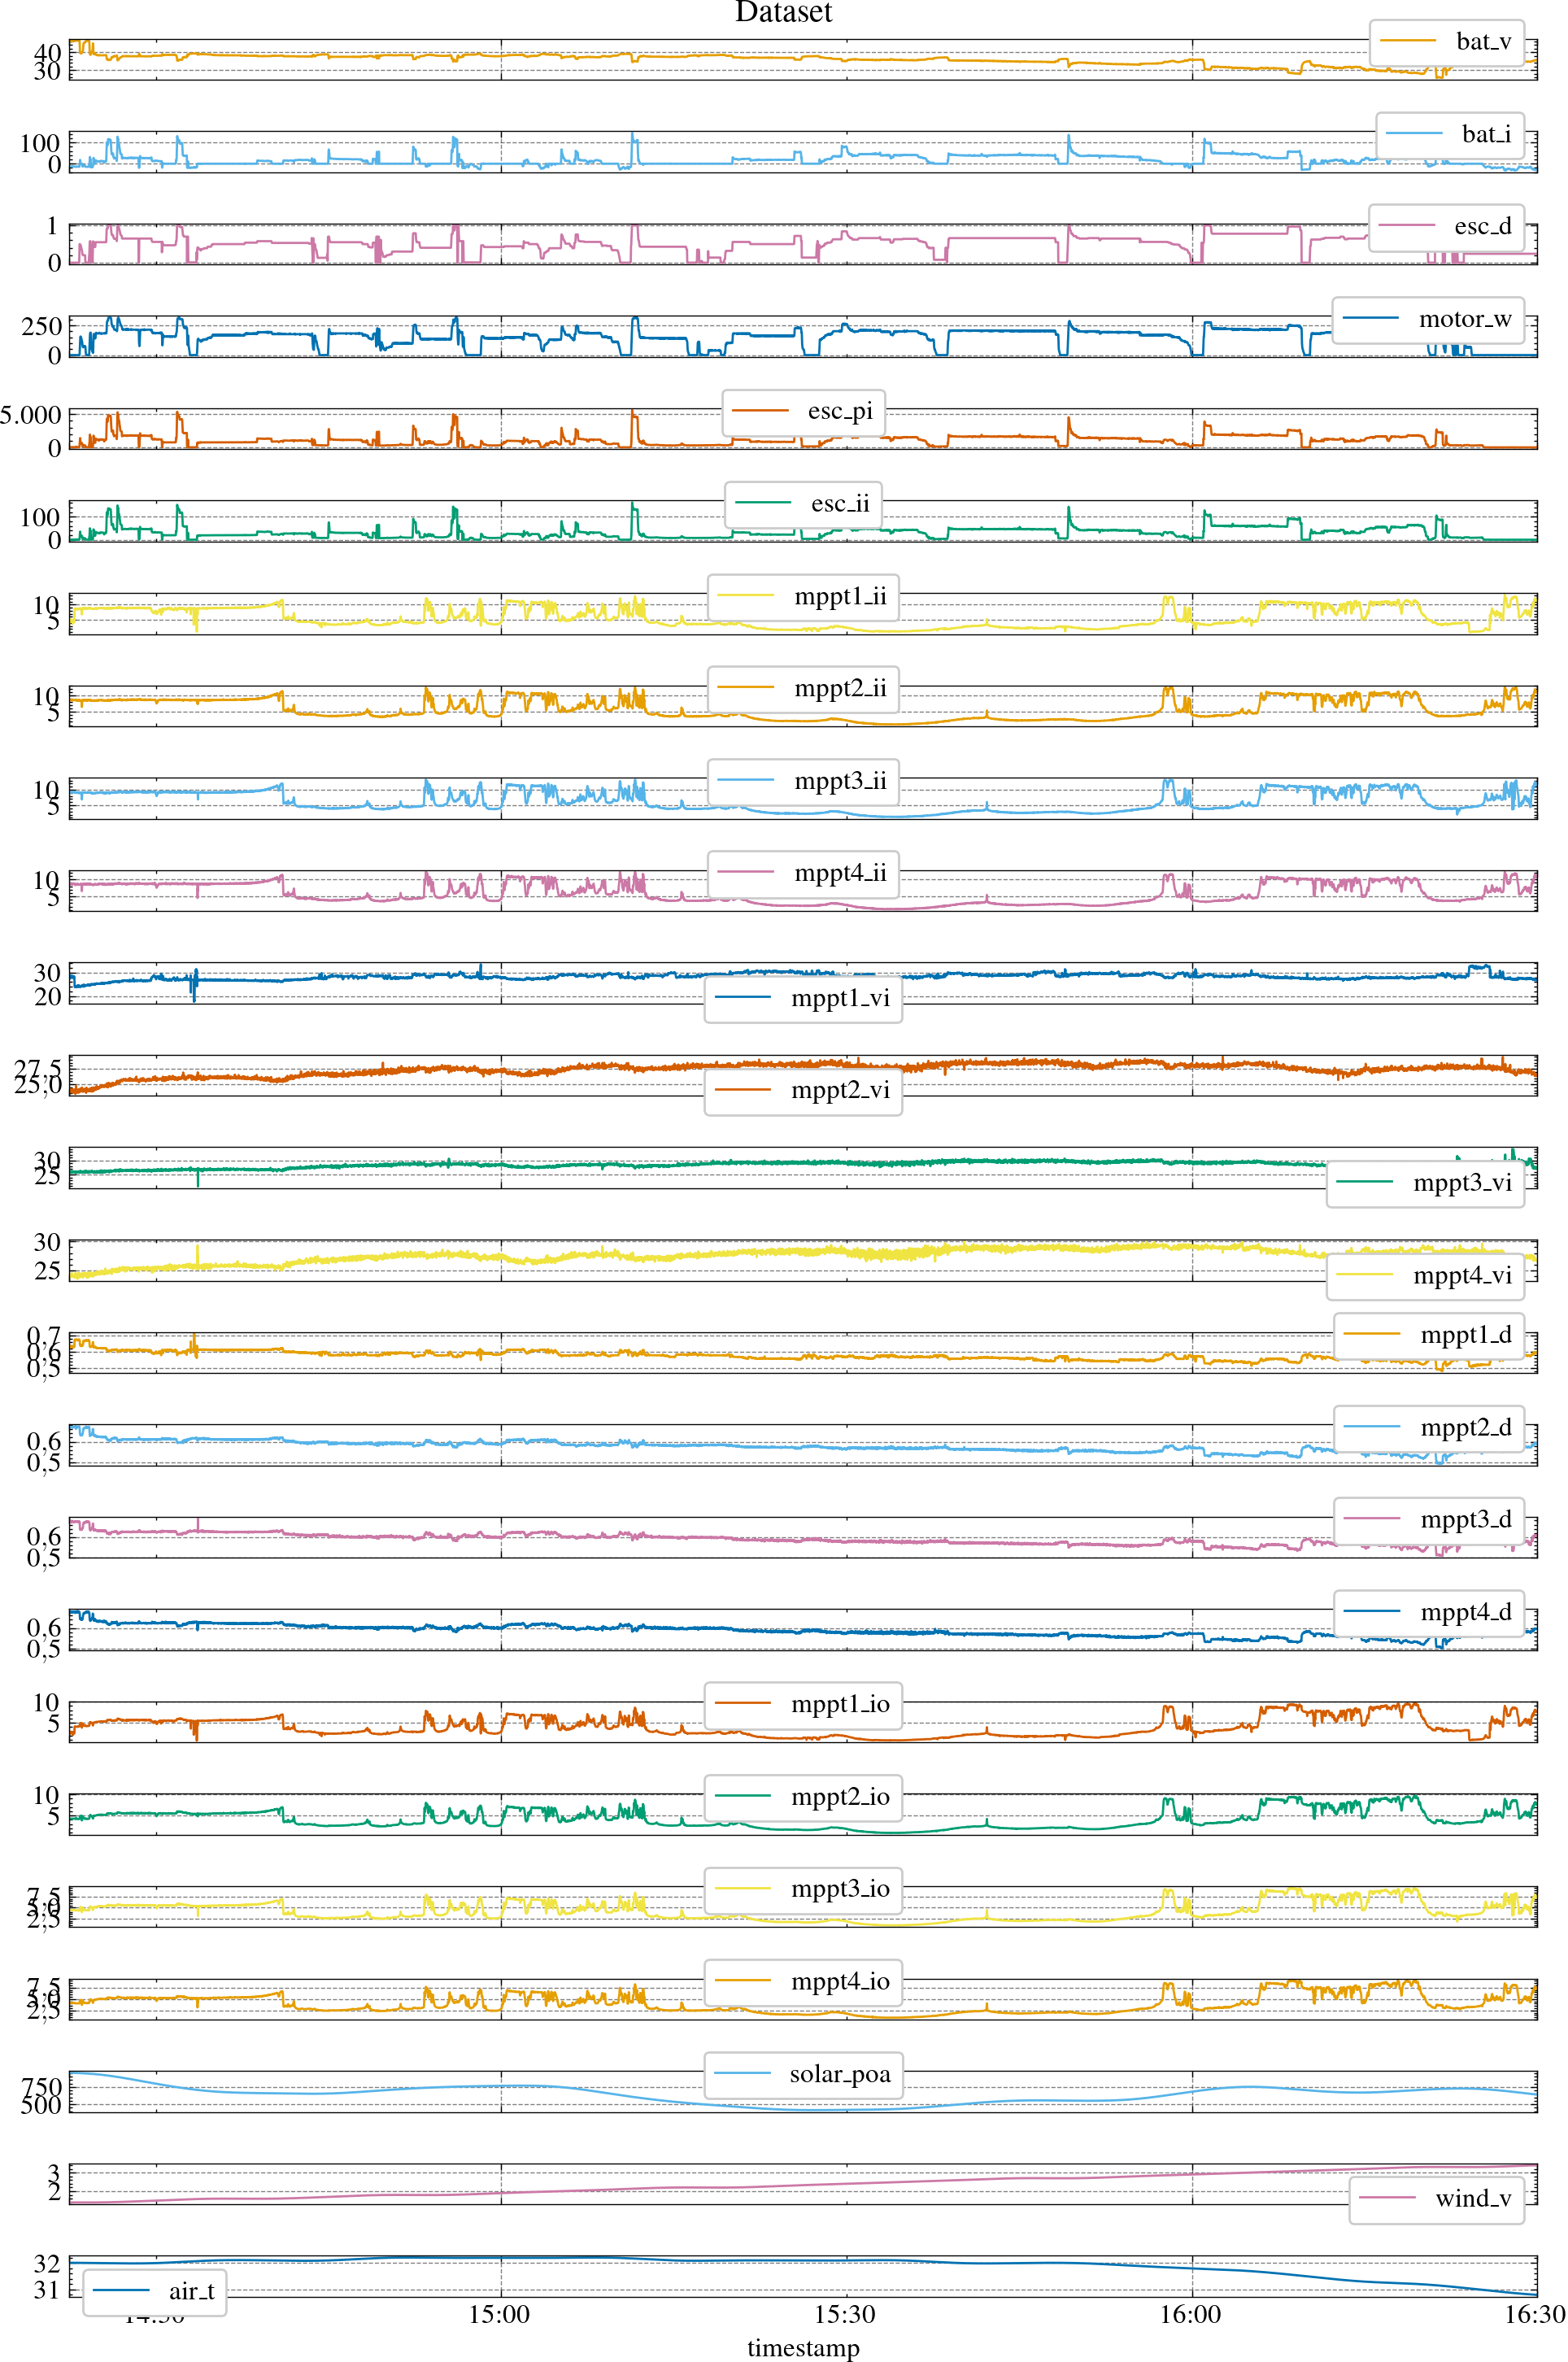

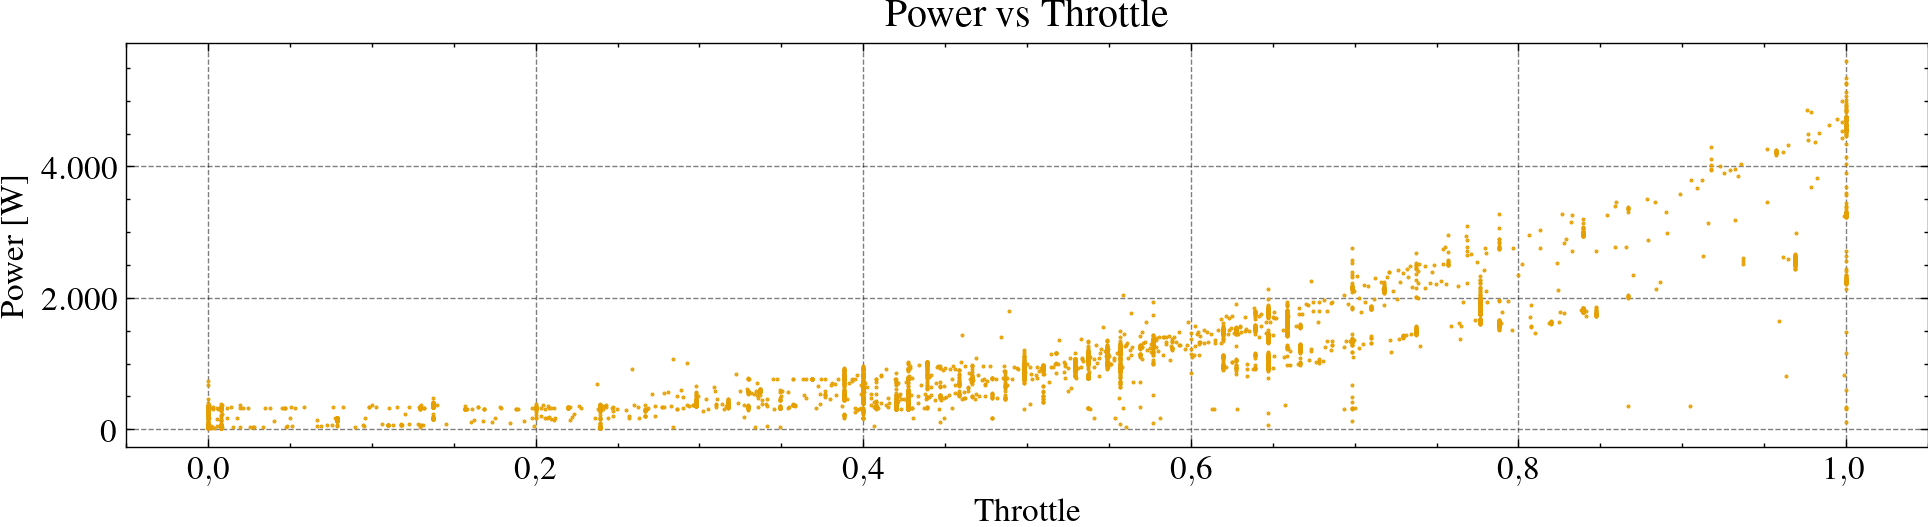

In [12]:
# From Revezamento
start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

df = vaex.from_csv("../../../models/2020/boat_data_1s.csv").to_pandas_df()
# df = vaex.from_csv("../../../models/2020/boat_data_100ms.csv").to_pandas_df()
df["timestamp"] = pd.DatetimeIndex(df["timestamp"]).tz_convert(None)
df = df.set_index("timestamp")
display('original columns:', df.columns)

renamed_columns = {
    'Battery Pack Voltage': 'bat_v',
    'Battery Current': 'bat_i',
    'ESC Duty Cycle': 'esc_d',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_pi',
    'ESC Input Current': 'esc_ii',
    **{f'MPPT {i} Input Current': f'mppt{i}_ii' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_vi' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_io' for i in range(1,5)},
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
display('renamed columns:', renamed_columns)

df = df.loc[
    (df.index >= start) & (df.index <= end),
    renamed_columns.keys(),
].rename(columns=renamed_columns)

display('selected columns:', df.columns)

df = df.dropna()
df = df.resample('1s').mean().interpolate(method="time", limit_area='inside')
dfa = df.copy(deep=True)

df.plot(subplots=True, figsize=(10, 15))
plt.suptitle('Dataset')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.title('Power vs Throttle')
plt.xlabel('Throttle')
plt.ylabel('Power [W]')
plt.scatter(df['esc_d'], df['esc_pi'], s=0.2)
plt.tight_layout()
plt.show()


# Parameters

In [13]:
propulsion_params = {
    'motor_R': 0.033757265716427315,
    'motor_L': 0.0010492267299141082,
    'motor_B': 0.003901852250197858,
    'motor_J': 0.039200000000000006,
    'motor_J_load': 7.740892852532529e-05,
    'motor_K': 0.10324265711774457,
    'prop_K': 0.0016398967597139407,
    'prop_D': 0.20511514437186884,
    'rho': 1025,
    'trans_eff': 0.95,
    'esc_eff': 0.8,
    'trans_K': 0.5909090909090909
}
generation_params = {
    'pv_area': 1.650 * 0.992,
    'pv_eff': 0.1589,
    'mppt_eff': 0.9303414194668972,
    'mppt_n': 4,
}
battery_params = { # From: modelling_battery_nonlinear-sprint-dataset.ipynb
    'bat_eff': 1,
    'bat_Q': 38 * 3600,
    'bat_R_0': 0.07688995265604726,
    'bat_R_1': 0.007914593252093682,
    'bat_C_1': 22.97248164632932,
    'bat_coeffs': [25.4633167882052, 37.126691660372906, -21.115645449324788, -30.02431761749073, 29.382700604694268],
}
solar_boat_params = generation_params | battery_params | propulsion_params

# Solar Boat System model

In [31]:
import control as ct

class SolarBoat:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Parameters
        bat_R1, bat_C1, bat_Q, bat_eff, motor_K, motor_R, motor_L, motor_J, motor_B, motor_J_load = (
            params['bat_R_1'],  # battery internal serie-parallel resistance [Ohms]
            params['bat_C_1'],  # battery internal serie-parallel capacitance [Ohms]
            params['bat_Q'],  # battery Capacity [Ah]
            params['bat_eff'],  # battery efficency [unitless]
            params['motor_K'],  # Motor torque constant [Nm/A]
            params['motor_R'],  # Motor internal resistance [Ohms]
            params['motor_L'],  # Motor internal inductance [H]
            params['motor_J'],  # Motor inertia [kg m^2]
            params['motor_B'],  # Motor viscous friction coefficient [Nm/(rad/s)]
            params['motor_J_load'],  # Motor load inertia [kg m^2]
        )

        # States
        bat_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        bat_i = y[2]
        motor_w = y[5]
        motor_v = y[6]
        motor_load_q = y[7]

        # System of differential equations
        bat_di_R1_dt = (-bat_i_R1 + bat_i) * (1 / (bat_R1 * bat_C1))
        bat_dSOC_dt = -bat_eff * bat_i / bat_Q
        motor_didt = (-(motor_R * motor_i) - (motor_K * motor_w) + motor_v) / motor_L
        motor_dwdt = (+(motor_K * motor_i) - (motor_B * motor_w) - motor_load_q) / (motor_J + motor_J_load)

        return bat_di_R1_dt, bat_dSOC_dt, motor_didt, motor_dwdt

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Parameters
        pv_eff, pv_area, mppt_eff, mppt_n, bat_R0, bat_R1, bat_coeffs, prop_KQ, prop_D, rho, trans_eff, trans_K, esc_eff = (
            params['pv_eff'],  # Photovoltaic Panel average efficiency [unitless]
            params['pv_area'],  # Photovoltaic Panel total area [m^2]
            params['mppt_eff'],  # MPPT efficiency [unitless]
            params['mppt_n'],  # Number of solar panels + mppt arrays
            params['bat_R_0'],  # battery internal series resistance [Ohms]
            params['bat_R_1'],  # battery internal serie-parallel resistance [Ohms]
            params['bat_coeffs'],  # battery OCV(SOC) polynomial coefficients [V]
            params['prop_K'],  # Propeller Torque constant [Nm / (kg m^2 (rad / s)^2)]
            params['prop_D'],  # Propeller diameter [m]
            params['rho'],  # Water density [kg/m^3]
            params['trans_eff'],  # Transmission efficiency [unitless]
            params['trans_K'],  # Transmission gear ratio as `output speed / input speed` [unitless]
            params['esc_eff'],  # ESC efficiency [unitless]
        )

        # Inputs
        G = u[0]  # Total incident irradiance [W/m^2]
        esc_d = u[1]  # ESC duty-cycle

        # States
        bat_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        bat_SOC = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Simplified Photovoltaic Panel + MPPT
        mppt_po = G * pv_area * pv_eff * mppt_eff * mppt_n

        # ESC
        esc_d = np.clip(esc_d, 0, 1)
        esc_ii = motor_i * esc_d / esc_eff

        # battery
        bat_OCV = np.polynomial.Polynomial(bat_coeffs)(bat_SOC)
        # The following three equations could be solved for (bat_i, bat_v) simultaneously:
        #       mppt_io = (mppt_po / bat_v) if bat_v > 0 else 0
        #       bat_i = esc_ii - mppt_io
        #       bat_v = -bat_R1 * bat_i_R1 -bat_R0 * bat_i + bat_OCV
        # But for simplicity, they were combined into the following single equation:
        #       bat_v = -bat_R1 * bat_i_R1 -bat_R0 * (esc_ii - ((mppt_po / bat_v))) + bat_OCV
        # Then, if we solve it for bat_v, we get:
        bat_v = (-(bat_R1 * bat_i_R1) - (bat_R0 * esc_ii) + bat_OCV + np.sqrt((bat_R1**2 * bat_i_R1**2) + (2 * bat_R1 * bat_i_R1 * bat_R0 * esc_ii) + (bat_R0**2 * esc_ii**2) + (4 * bat_R0 * mppt_po) - (2 * bat_R1 * bat_i_R1 * bat_OCV) - (2 * bat_R0 * esc_ii * bat_OCV) + bat_OCV**2)) / 2
        # bat_v = np.clip(np.nan_to_num(bat_v), 21, 60)

        # ESC
        motor_v = esc_d * bat_v

        # # MPPT
        mppt_io = mppt_po / bat_v if bat_v != 0 else 0

        # # battery current node
        bat_i = esc_ii - mppt_io

        hull_S = 1
        hull_C = 1
        prop_eff = 0.5

        # # Propeller
        prop_w = motor_w * trans_K
        prop_q = (prop_D ** 5) * rho * prop_KQ * (prop_w ** 2)
        # motor_load_q = prop_q * trans_K / trans_eff
        motor_load_q = prop_D**7*rho*prop_KQ**2*(prop_D + np.sqrt((4.0*hull_S*hull_C + prop_D**2*np.pi)/np.pi))*motor_w**3/(hull_S*hull_C*trans_eff*trans_K**4*prop_eff)

        return bat_v, bat_SOC, bat_i, mppt_io, esc_ii, motor_w, motor_v, motor_load_q


    @classmethod
    def build(cls, params: dict = {}):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='boat',
            states=('bat_i_R1', 'bat_SOC', 'motor_i', 'motor_w'),
            inputs=('G', 'D'),
            outputs=('bat_v', 'bat_SOC', 'bat_i', 'bat_ii', 'esc_ii', 'motor_w', 'motor_v', 'motor_q'),
            params=params,
        )

In [32]:
SolarBoat.build(solar_boat_params)

<NonlinearIOSystem:boat:['G', 'D']->['bat_v', 'bat_SOC', 'bat_i', 'bat_ii', 'esc_ii', 'motor_w', 'motor_v', 'motor_q']>

In [33]:
df = dfa.copy(deep=True)#.resample('30min').mean()
# df = df.iloc[:1000]
# df.index[-1] - df.index[0]

In [34]:
# Time array
T = (df.index[1] - df.index[0]).to_numpy().astype(np.float64) * 1e-9   # simulation time in seconds
lenT = len(df.index)
T = np.linspace(0, lenT * T, lenT, endpoint=False)  # Recreate the time array because of numerical issues from the index datetime to float transformation

# Data
U = df[['solar_poa', 'esc_d']].to_numpy().T

solar_boat = SolarBoat.build(solar_boat_params)

X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['bat_SOC']] = 1

res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='LSODA', solve_ivp_kwargs=dict(max_step=np.inf))
ydata = res.to_pandas().set_index('time')[res.output_labels]

# ydata.plot(subplots=True, figsize=(10,7));

In [35]:
def plot_compare(column: str):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    ax1.plot(ydata.index, df[column], label='data')
    ax1.plot(ydata.index, ydata[column], label='model')
    ax1.set_title(f'Comparing {column}')
    ax1.legend()

    error = df[column].to_numpy() - ydata[column].to_numpy()

    ax2.plot(ydata.index, error, label='error', color='gray')

    mean_error = np.mean(error)
    rms_error = np.sqrt(np.mean(error**2))
    accumulated_error = np.sum(error)

    ax2.set_title(f'Error in {column} (Mean: {mean_error:.2f}, RMS: {rms_error:.2f}, Accumulated: {accumulated_error:.2f})')
    ax2.legend()

    plt.tight_layout()
    plt.show()


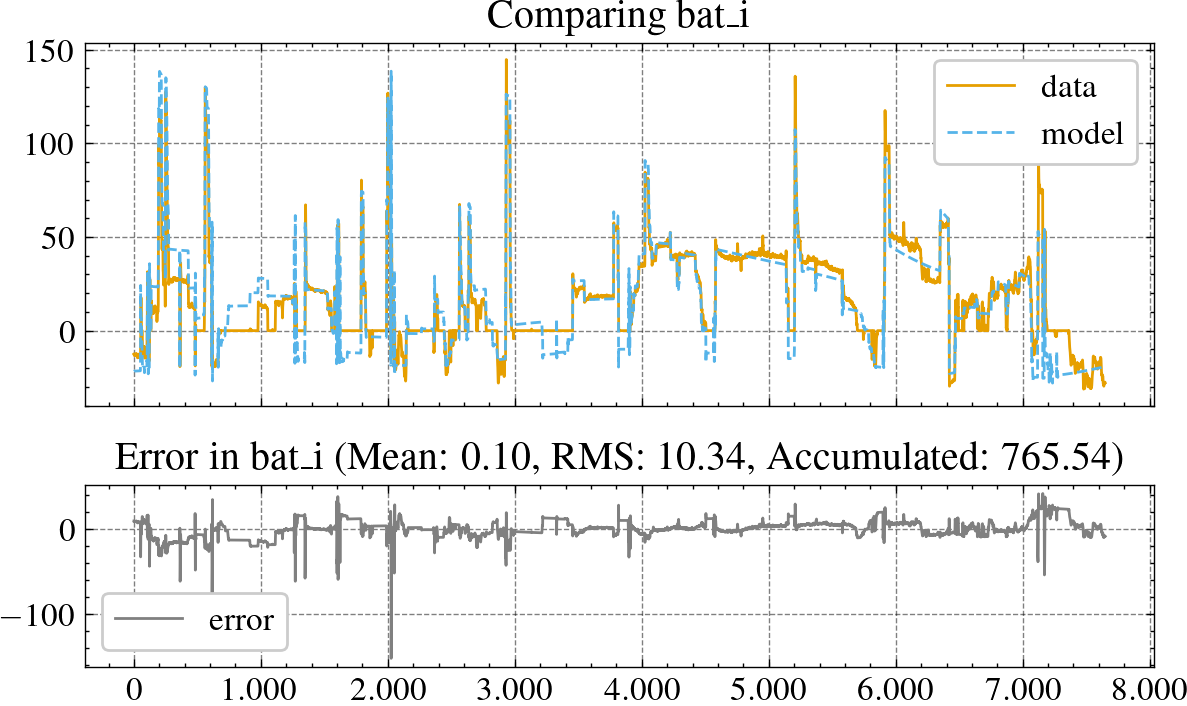

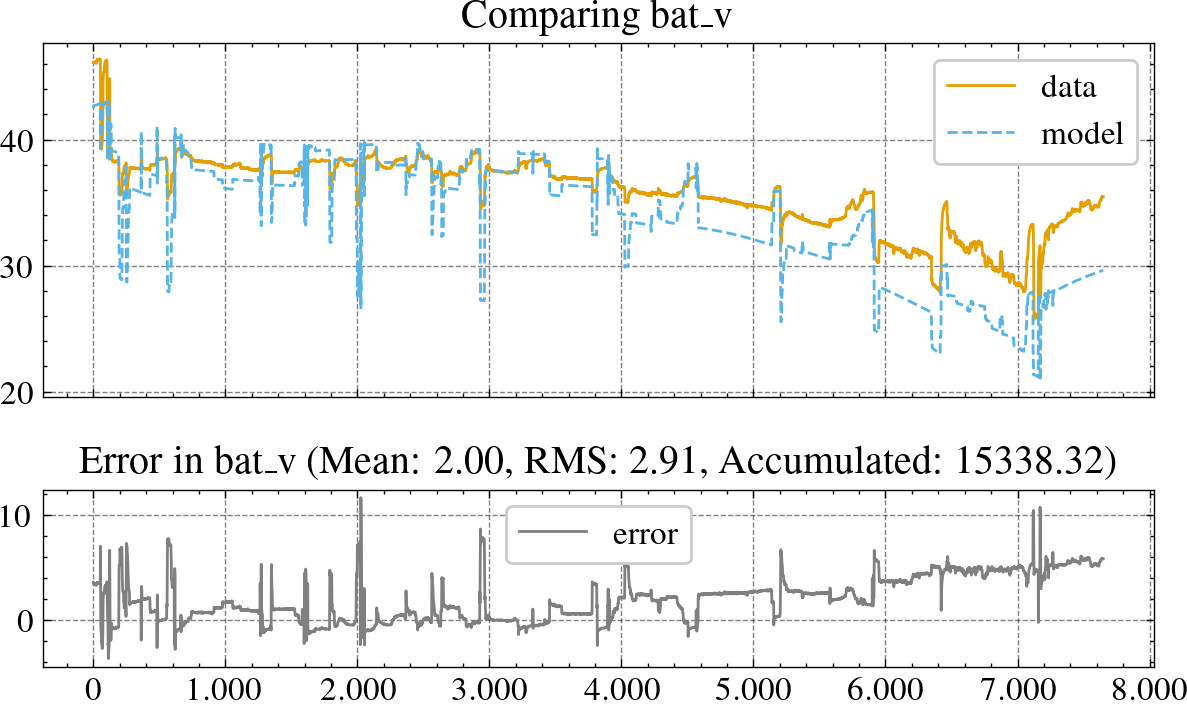

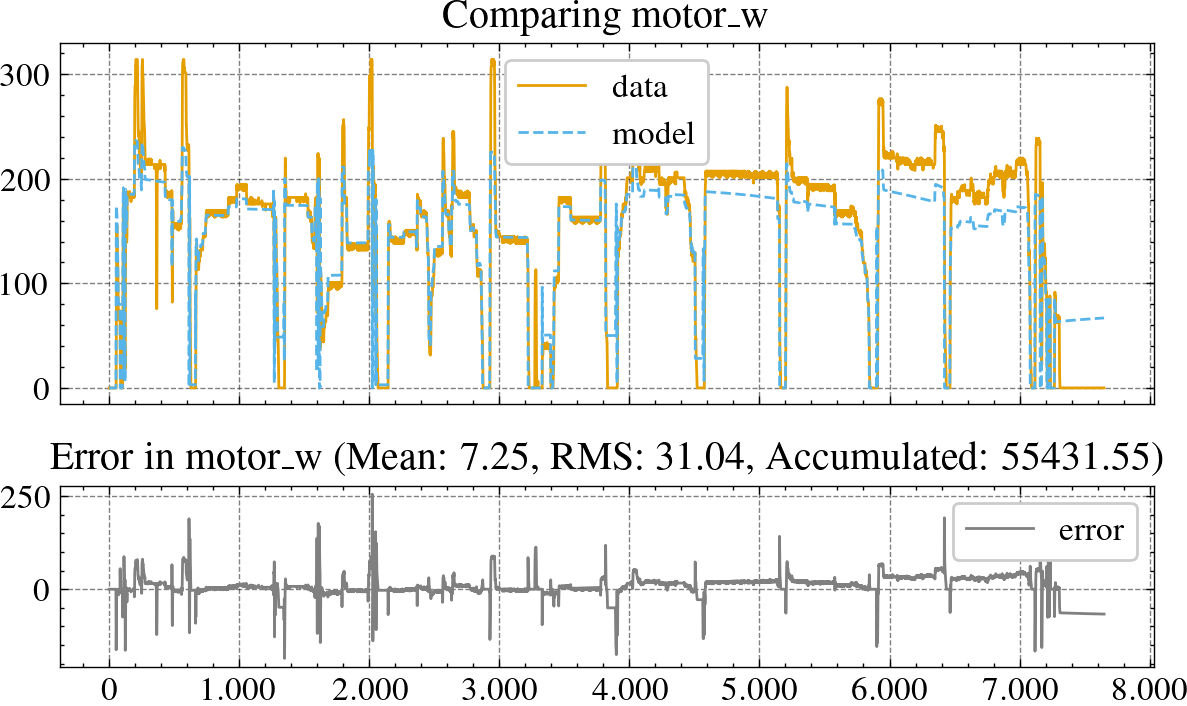

In [36]:
plot_compare('bat_i')
plot_compare('bat_v')
plot_compare('motor_w')